# SALAMI → EDM Segmentation Pipeline
**TECHIN 513 — Music Visual Generator** | Anthony Chen & Rebecca Yang

---

## What this notebook does

Instead of manually labeling every song, we use the **SALAMI dataset** — 1300+ pre-annotated songs — as training data, then **fine-tune on a small set of your own EDM labels** to adapt the model to drop/buildup/breakdown/calm classification.

### Two-stage strategy
```
STAGE 1 — SALAMI pre-training
  SALAMI annotations (Verse/Chorus/Bridge...)
       ↓ remap to EDM labels
  Train Random Forest on ~100 songs worth of data
       ↓
  General boundary-aware model

STAGE 2 — EDM fine-tuning
  Your 5-8 manually labeled EDM tracks (from edm_annotator.html)
       ↓
  Fine-tune / retrain with EDM data weighted higher
       ↓
  Final EDM-specific classifier  ✅
```

### Notebook structure
| Step | What happens |
|---|---|
| **1** | Install dependencies |
| **2** | Download SALAMI annotations via `mirdata` |
| **3** | Download matching audio from YouTube |
| **4** | Explore SALAMI label vocabulary |
| **5** | Define SALAMI → EDM label mapping |
| **6** | Extract audio features for all SALAMI tracks |
| **7** | Build SALAMI training dataset (X, y) |
| **8** | Load your EDM manual labels |
| **9** | Train Stage 1 model on SALAMI |
| **10** | Fine-tune Stage 2 on EDM tracks |
| **11** | Evaluate + visualize results |
| **12** | Save final model |


---
## Step 1 — Install Dependencies
Run this once. Restart the kernel after installation completes.

In [9]:
# Install everything needed
import subprocess, sys

packages = [
    'mirdata',        # SALAMI dataset loader
    'librosa',        # audio feature extraction
    'scikit-learn',   # ML classifiers
    'matplotlib',
    'numpy',
    'pandas',
    'scipy',
    'joblib',         # saving/loading models
    'tqdm',           # progress bars
    'yt-dlp',         # YouTube audio download
    'static-ffmpeg'
]

for pkg in packages:
    print(f'Installing {pkg}...')
    subprocess.run([sys.executable, '-m', 'pip', 'install', pkg, '-q'], check=True)

print('\n✅ All packages installed — RESTART THE KERNEL NOW, then continue from Step 2')

Installing mirdata...
Installing librosa...
Installing scikit-learn...
Installing matplotlib...
Installing numpy...
Installing pandas...
Installing scipy...
Installing joblib...
Installing tqdm...
Installing yt-dlp...
Installing static-ffmpeg...

✅ All packages installed — RESTART THE KERNEL NOW, then continue from Step 2


In [10]:
import static_ffmpeg
static_ffmpeg.add_paths()
print('✅ ffmpeg ready')

# Verify
import subprocess
result = subprocess.run(['ffmpeg', '-version'], capture_output=True, text=True)
print(result.stdout[:100])

✅ ffmpeg ready
ffmpeg version n8.0.1-48-g0592be14ff-20260116 Copyright (c) 2000-2025 the FFmpeg developers
built wi


---
## Step 2 — Imports & Configuration
⚙️ **Edit the paths at the top of this cell before running anything else.**

In [11]:
import os, csv, warnings, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa
import librosa.display
import mirdata
import joblib
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.dpi'] = 110

# ── ⚙️  EDIT THESE PATHS ────────────────────────────────────────────────────
SALAMI_DATA_DIR   = './salami_data'          # where SALAMI annotations + audio go
SALAMI_PUBLIC_DIR = './salami_data/salami-data-public'  # cloned salami-data-public repo (function annotations)
EDM_LABELS_DIR   = './edm_labels'           # folder with your *_labels.csv files
EDM_AUDIO_DIR    = './edm_audio'            # folder with your EDM .mp3 files
OUTPUT_DIR       = './output'               # where datasets + model are saved

# How many SALAMI tracks to process (start with 50 to test, use 200+ for full run)
MAX_SALAMI_TRACKS = 200
# ────────────────────────────────────────────────────────────────────────────

for d in [SALAMI_DATA_DIR, EDM_LABELS_DIR, EDM_AUDIO_DIR, OUTPUT_DIR]:
    os.makedirs(d, exist_ok=True)

# Shared constants
LABEL_COLORS = {'drop': '#FF4444', 'buildup': '#FF9900', 'breakdown': '#AA44FF', 'calm': '#44AAFF'}
LABEL_INT    = {'calm': 0, 'breakdown': 1, 'buildup': 2, 'drop': 3}
INT_LABEL    = {v: k for k, v in LABEL_INT.items()}
HOP          = 512
SR           = 22050

print('✅ Imports OK')
print(f'   SALAMI data  → {SALAMI_DATA_DIR}')
print(f'   EDM labels   → {EDM_LABELS_DIR}')
print(f'   EDM audio    → {EDM_AUDIO_DIR}')
print(f'   Outputs      → {OUTPUT_DIR}')

✅ Imports OK
   SALAMI data  → ./salami_data
   EDM labels   → ./edm_labels
   EDM audio    → ./edm_audio
   Outputs      → ./output


---
## Step 3 — Download SALAMI Annotations
This downloads **only the annotation files** (no audio yet — that comes next).
Takes ~1–2 minutes on first run. Subsequent runs are instant (already cached).

In [12]:
print('Initializing SALAMI dataset...')
salami = mirdata.initialize('salami', data_home=SALAMI_DATA_DIR)

print('Downloading annotations (first run only)...')
salami.download(['annotations'])

track_ids = salami.track_ids
print(f'\n✅ SALAMI ready')
print(f'   Total tracks in dataset : {len(track_ids)}')
print(f'   Tracks we will process  : {MAX_SALAMI_TRACKS}')
print(f'   Track ID examples       : {track_ids[:8]}')

Initializing SALAMI dataset...


    Unfortunately the audio files of the Salami dataset are not available
    for download. If you have the Salami dataset, place the contents into a
    folder called Salami with the following structure:
        > Salami/
            > salami-data-public-hierarchy-corrections/
            > audio/
    and copy the Salami folder to ./salami_data




✅ SALAMI ready
   Total tracks in dataset : 1359
   Tracks we will process  : 200
   Track ID examples       : ['602', '488', '1477', '787', '911', '1059', '491', '742']


### Step 3b — Clone `salami-data-public` for Function Annotations
The `mirdata` download only includes the hierarchy-corrections version, which lacks function labels
(intro, verse, chorus, etc.). We clone the original `salami-data-public` repo to get them.
This is a ~15MB download and only needs to run once.

In [13]:
import subprocess, os

SALAMI_PUBLIC_REPO = 'https://github.com/DDMAL/salami-data-public.git'

if os.path.isdir(SALAMI_PUBLIC_DIR):
    print(f'✅ salami-data-public already cloned → {SALAMI_PUBLIC_DIR}')
else:
    print(f'Cloning salami-data-public → {SALAMI_PUBLIC_DIR} ...')
    result = subprocess.run(
        ['git', 'clone', '--depth', '1', SALAMI_PUBLIC_REPO, SALAMI_PUBLIC_DIR],
        capture_output=True, text=True
    )
    if result.returncode == 0:
        print('✅ Clone complete')
    else:
        print('❌ Clone failed:')
        print(result.stderr)
        print()
        print('If git is unavailable, download the zip manually from:')
        print('  https://github.com/DDMAL/salami-data-public/archive/refs/heads/master.zip')
        print(f'and extract it to: {SALAMI_PUBLIC_DIR}')

# Verify a sample function annotation file exists
sample_fn = os.path.join(SALAMI_PUBLIC_DIR, 'annotations', '2', 'parsed', 'textfile1_functions.txt')
if os.path.exists(sample_fn):
    print(f'✅ Function annotations confirmed present (sample: {sample_fn})')
else:
    print(f'⚠️  Sample function file not found at expected path: {sample_fn}')
    print('   Check your SALAMI_PUBLIC_DIR path in Step 2.')


Cloning salami-data-public → ./salami_data/salami-data-public ...
✅ Clone complete
✅ Function annotations confirmed present (sample: ./salami_data/salami-data-public/annotations/2/parsed/textfile1_functions.txt)


In [14]:
# ── Helper: load function annotations from salami-data-public ────────────────
def load_salami_function_annotations(salami_id, salami_public_dir):
    """
    Load function-level annotations (intro, verse, chorus, bridge...)
    from the salami-data-public repo for a given track ID.
    Tries annotator 1 first, then annotator 2.
    Returns a list of {'start', 'end', 'label'} dicts, or None if not found.
    """
    for annotator in ['1', '2']:
        path = os.path.join(
            salami_public_dir,
            'annotations', str(salami_id),
            'parsed', f'textfile{annotator}_functions.txt'
        )
        if not os.path.exists(path):
            continue
        onsets, labels = [], []
        with open(path) as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                parts = line.split('\t')
                if len(parts) >= 2:
                    try:
                        onsets.append(float(parts[0]))
                        labels.append(parts[1].strip().lower())
                    except ValueError:
                        continue
        if not onsets:
            continue
        # Convert onset list → [start, end] pairs
        segments = []
        for i in range(len(labels)):
            start = onsets[i]
            end   = onsets[i + 1] if i + 1 < len(onsets) else start + 60
            lbl   = labels[i]
            # Skip silence / end markers that aren't real section labels
            if lbl in ('', 'end', 'silence'):
                lbl = 'silence'
            segments.append({'start': start, 'end': end, 'label': lbl})
        return segments
    return None   # Neither annotator had function annotations

print('✅ load_salami_function_annotations() defined')
print('   Reads textfile1_functions.txt / textfile2_functions.txt from salami-data-public')


✅ load_salami_function_annotations() defined
   Reads textfile1_functions.txt / textfile2_functions.txt from salami-data-public


---
## Step 4 — Download Audio from YouTube
SALAMI doesn't include audio files — we download the matching YouTube videos.
The `matching-salami` project has a CSV pairing SALAMI track IDs to YouTube IDs.

> ⏱️ **This takes a while.** Each song = ~1–2 min to download. Run it, go get coffee.
> You can re-run safely — it skips already-downloaded files.

In [15]:
# Download the YouTube pairings CSV from the matching-salami project
pairings_url = (
    'https://raw.githubusercontent.com/jblsmith/matching-salami/master/'
    'salami_youtube_pairings.csv'
)
pairings_path = os.path.join(SALAMI_DATA_DIR, 'salami_youtube_pairings.csv')

if not os.path.exists(pairings_path):
    print('Downloading YouTube pairings CSV...')
    subprocess.run(['curl', '-sL', pairings_url, '-o', pairings_path], check=True)
    print(f'  Saved → {pairings_path}')
else:
    print(f'✅ Pairings CSV already exists: {pairings_path}')

pairings = pd.read_csv(pairings_path)
print(f'\nPairings CSV shape: {pairings.shape}')
print(pairings.head(3).to_string())

  Saved → ./salami_data/salami_youtube_pairings.csv

Pairings CSV shape: (671, 8)
   salami_id  salami_length   youtube_id  youtube_length  coverage  coverage_percent  onset_in_youtube  onset_in_salami
0          2     264.800000  DKzFw_i6Ffg           265.0     261.4          0.987160               0.6              0.5
1          3     276.662812  E6iGez4BLjQ           277.0     270.3          0.977002               0.3              0.5
2          4     236.094667  ct8gCRPST9s           235.0     232.5          0.984774               0.4              0.5


In [16]:
# ── Step 4a: Inspect the CSV so we know exactly what columns exist ───────────
audio_dir = os.path.join(SALAMI_DATA_DIR, 'audio')
os.makedirs(audio_dir, exist_ok=True)

print('CSV columns:', pairings.columns.tolist())
print(f'CSV shape  : {pairings.shape}')
print()
print('First 5 rows:')
print(pairings.head().to_string())

CSV columns: ['salami_id', 'salami_length', 'youtube_id', 'youtube_length', 'coverage', 'coverage_percent', 'onset_in_youtube', 'onset_in_salami']
CSV shape  : (671, 8)

First 5 rows:
   salami_id  salami_length   youtube_id  youtube_length  coverage  coverage_percent  onset_in_youtube  onset_in_salami
0          2     264.800000  DKzFw_i6Ffg           265.0     261.4          0.987160               0.6              0.5
1          3     276.662812  E6iGez4BLjQ           277.0     270.3          0.977002               0.3              0.5
2          4     236.094667  ct8gCRPST9s           235.0     232.5          0.984774               0.4              0.5
3          5     256.940417  IBdrzoz9o0o           258.0     248.1          0.965594               6.0              6.0
4          6     170.466667  QurVLnYoFqo           174.0     163.5          0.959132               4.8              0.2


In [17]:
# ── Step 4b: Detect the SALAMI ID column and YouTube ID column robustly ──────
#
# The matching-salami CSV has been updated several times.
# Common column name variants:
#   SALAMI ID  → 'SALAMI_ID', 'salami_id', first column
#   YouTube ID → 'youtube_id', 'yt_id', 'video_id', or embedded in a URL column
#
# Run Step 4a first, then set these manually if auto-detection fails.

def detect_column(df, keywords):
    """Find the first column whose name contains any of the keywords."""
    for col in df.columns:
        if any(k in col.lower() for k in keywords):
            return col
    return None

# Auto-detect
SALAMI_ID_COL = detect_column(pairings, ['salami', 'id'])
YT_ID_COL     = detect_column(pairings, ['youtube', 'yt_id', 'video_id', 'url'])

# ── ⚙️  OVERRIDE HERE if auto-detection picked the wrong column ─────────────
# SALAMI_ID_COL = 'SALAMI_ID'   # uncomment and set manually if needed
# YT_ID_COL     = 'youtube_id'  # uncomment and set manually if needed
# ────────────────────────────────────────────────────────────────────────────

print(f'Using SALAMI ID column : "{SALAMI_ID_COL}"')
print(f'Using YouTube ID column: "{YT_ID_COL}"')
print()

if SALAMI_ID_COL is None or YT_ID_COL is None:
    print('❌ Could not auto-detect columns.')
    print('   Look at the output of Step 4a and set SALAMI_ID_COL / YT_ID_COL manually above.')
else:
    # Sample values so you can confirm they look right
    sample = pairings[[SALAMI_ID_COL, YT_ID_COL]].dropna().head(5)
    print('Sample rows (confirm these look like SALAMI IDs + YouTube IDs):')
    print(sample.to_string(index=False))

Using SALAMI ID column : "salami_id"
Using YouTube ID column: "youtube_id"

Sample rows (confirm these look like SALAMI IDs + YouTube IDs):
 salami_id  youtube_id
         2 DKzFw_i6Ffg
         3 E6iGez4BLjQ
         4 ct8gCRPST9s
         5 IBdrzoz9o0o
         6 QurVLnYoFqo


In [18]:
# ── Step 4c: Extract a clean 11-character YouTube ID from whatever format ────
import re

def extract_yt_id(raw):
    """
    Handles all YouTube ID formats seen in the wild:
      - Plain 11-char ID       : 'dQw4w9WgXcQ'
      - Full URL               : 'https://www.youtube.com/watch?v=dQw4w9WgXcQ'
      - Short URL              : 'https://youtu.be/dQw4w9WgXcQ'
      - URL with extra params  : 'https://youtube.com/watch?v=dQw4w9WgXcQ&t=30'
    Returns None if no valid ID found.
    """
    if not isinstance(raw, str) or not raw.strip():
        return None
    raw = raw.strip()

    # Try extracting from URL first
    url_match = re.search(r'(?:v=|youtu\.be/)([A-Za-z0-9_-]{11})', raw)
    if url_match:
        return url_match.group(1)

    # Plain 11-char ID
    if re.fullmatch(r'[A-Za-z0-9_-]{11}', raw):
        return raw

    return None   # Could not parse


# Apply to the pairings dataframe
pairings['_yt_id_clean'] = pairings[YT_ID_COL].apply(extract_yt_id)
pairings['_salami_id_clean'] = pairings[SALAMI_ID_COL].apply(
    lambda x: str(int(float(x))) if pd.notna(x) else None
)

matched = pairings.dropna(subset=['_yt_id_clean', '_salami_id_clean']).head(MAX_SALAMI_TRACKS)

print(f'Rows with valid YouTube IDs : {pairings["_yt_id_clean"].notna().sum()}')
print(f'Rows we will download (cap) : {len(matched)}')
print()
print('Sample cleaned IDs:')
print(matched[['_salami_id_clean', '_yt_id_clean']].head(5).to_string(index=False))

Rows with valid YouTube IDs : 671
Rows we will download (cap) : 200

Sample cleaned IDs:
_salami_id_clean _yt_id_clean
               2  DKzFw_i6Ffg
               3  E6iGez4BLjQ
               4  ct8gCRPST9s
               5  IBdrzoz9o0o
               6  QurVLnYoFqo


In [19]:
audio_dir = os.path.join(SALAMI_DATA_DIR, 'audio')
os.makedirs(audio_dir, exist_ok=True)

ok, skip, failed = [], [], []

for _, row in tqdm(matched.iterrows(), total=len(matched), desc='Downloading audio'):
    salami_id = row['_salami_id_clean']
    yt_id     = row['_yt_id_clean']

    # Accept any already-downloaded format
    existing = [f for f in os.listdir(audio_dir)
                if f.startswith(f'{salami_id}.') and
                f.endswith(('.mp3', '.m4a', '.webm', '.opus', '.ogg'))]
    if existing:
        skip.append(salami_id)
        continue

    # Download best audio, NO conversion (avoids ffmpeg requirement)
    out_template = os.path.join(audio_dir, f'{salami_id}.%(ext)s')
    cmd = [
        sys.executable, '-m', 'yt_dlp',
        '-f', 'bestaudio',          # best audio stream, no conversion
        '--no-playlist',
        '--quiet',
        '--no-warnings',
        '-o', out_template,
        f'https://www.youtube.com/watch?v={yt_id}'
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)

    # Check if any audio file appeared
    downloaded = [f for f in os.listdir(audio_dir)
                  if f.startswith(f'{salami_id}.')]
    if downloaded:
        ok.append(salami_id)
        print(f'  ✓ {salami_id} → {downloaded[0]}')
    else:
        # Print the FULL stderr so we can see the real error
        err = (result.stderr or result.stdout or 'unknown error')
        # Strip the requests warning noise
        err_lines = [l for l in err.splitlines()
                     if 'RequestsDependencyWarning' not in l
                     and 'urllib3' not in l
                     and l.strip()]
        print(f'  ✗ {salami_id} ({yt_id}): {" | ".join(err_lines[:3])}')
        failed.append(salami_id)

print(f'\n✅ Downloaded : {len(ok)}')
print(f'⏭  Skipped   : {len(skip)}  (already existed)')
print(f'❌ Failed     : {len(failed)}  (unavailable/blocked)')
print(f'\nUsable tracks: {len(ok) + len(skip)} / {len(matched)}')

  ✗ 2 (DKzFw_i6Ffg):   warnings.warn( | ERROR: [youtube] DKzFw_i6Ffg: Video unavailable. This video is no longer available due to a copyright claim by The Smashing Pumpkins


  ✓ 3 → 3.webm


  ✗ 4 (ct8gCRPST9s):   warnings.warn( | ERROR: [youtube] ct8gCRPST9s: Video unavailable. This video is not available


  ✓ 5 → 5.webm


  ✗ 6 (QurVLnYoFqo):   warnings.warn( | ERROR: [youtube] QurVLnYoFqo: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


  ✓ 7 → 7.webm


  ✗ 8 (HF03S-1mVR8):   warnings.warn( | ERROR: [youtube] HF03S-1mVR8: Video unavailable. This video is not available


  ✓ 10 → 10.webm


  ✓ 11 → 11.webm


  ✓ 12 → 12.webm


  ✓ 13 → 13.webm


  ✗ 14 (Q5u1ZbIaNps):   warnings.warn( | ERROR: [youtube] Q5u1ZbIaNps: Requested format is not available. Use --list-formats for a list of available formats


  ✓ 16 → 16.webm


  ✓ 19 → 19.webm


  ✓ 21 → 21.webm


  ✓ 22 → 22.m4a


  ✓ 23 → 23.webm


  ✓ 24 → 24.webm


  ✓ 26 → 26.m4a


  ✓ 27 → 27.webm


  ✗ 28 (DYYjQGSIRhc):   warnings.warn( | ERROR: [youtube] DYYjQGSIRhc: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


  ✗ 30 (glN8XXfKJcs):   warnings.warn( | ERROR: [youtube] glN8XXfKJcs: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


  ✓ 31 → 31.webm


  ✓ 32 → 32.webm


  ✗ 36 (A_pwcKjfC5M):   warnings.warn( | ERROR: [youtube] A_pwcKjfC5M: Video unavailable. This video is not available


  ✓ 37 → 37.webm


  ✓ 38 → 38.m4a


  ✓ 39 → 39.webm


  ✓ 40 → 40.webm


  ✗ 43 (fLjQ-sNlaho):   warnings.warn( | ERROR: [youtube] fLjQ-sNlaho: Video unavailable. This video is not available


  ✗ 45 (24-O8eQFIXo):   warnings.warn( | ERROR: [youtube] 24-O8eQFIXo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


  ✗ 46 (ccB7s_IKCGQ):   warnings.warn( | ERROR: [youtube] ccB7s_IKCGQ: This video has been removed for violating YouTube's Terms of Service


  ✗ 47 (T2q8iyva2mw):   warnings.warn( | ERROR: [youtube] T2q8iyva2mw: Video unavailable. This video is not available


  ✗ 48 (C46DHQ5Tc_8):   warnings.warn( | ERROR: [youtube] C46DHQ5Tc_8: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


  ✓ 50 → 50.m4a


  ✓ 51 → 51.webm


  ✗ 52 (Qpq5kw0evJE):   warnings.warn( | ERROR: [youtube] Qpq5kw0evJE: Video unavailable. This video is not available


  ✓ 53 → 53.webm


  ✓ 54 → 54.m4a


  ✗ 55 (twhTfYKmdD0):   warnings.warn( | ERROR: [youtube] twhTfYKmdD0: Video unavailable


  ✓ 56 → 56.m4a


  ✓ 59 → 59.webm


  ✗ 60 (fyhTk596A9c):   warnings.warn( | ERROR: [youtube] fyhTk596A9c: Video unavailable. This video is not available


  ✓ 61 → 61.webm


  ✓ 63 → 63.webm


  ✓ 64 → 64.webm


  ✓ 66 → 66.webm


  ✓ 67 → 67.webm


  ✗ 68 (-99j6DeuwUI):   warnings.warn( | ERROR: [youtube] -99j6DeuwUI: The uploader has not made this video available in your country | You might want to use a VPN or a proxy server (with --proxy) to workaround.


  ✓ 69 → 69.webm


  ✗ 74 (UHGRHybvDK0):   warnings.warn( | ERROR: [youtube] UHGRHybvDK0: Video unavailable


  ✓ 75 → 75.webm


  ✓ 79 → 79.webm


  ✓ 82 → 82.webm


  ✗ 83 (0rnvM6Mj2vo):   warnings.warn( | ERROR: [youtube] 0rnvM6Mj2vo: The uploader has not made this video available in your country | You might want to use a VPN or a proxy server (with --proxy) to workaround.


  ✓ 86 → 86.webm


  ✗ 93 (NuzVY7srVVI):   warnings.warn( | ERROR: [youtube] NuzVY7srVVI: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


  ✓ 95 → 95.webm


  ✓ 96 → 96.webm


  ✓ 99 → 99.m4a


  ✓ 101 → 101.webm


  ✓ 102 → 102.webm


  ✓ 107 → 107.webm


  ✓ 108 → 108.webm


  ✗ 110 (UQCwlhm-nks):   warnings.warn( | ERROR: [youtube] UQCwlhm-nks: Video unavailable. This video is not available


  ✓ 111 → 111.webm


  ✓ 112 → 112.webm


  ✓ 114 → 114.webm


  ✓ 116 → 116.webm


  ✗ 118 (SeGjwmA-nao):   warnings.warn( | ERROR: [youtube] SeGjwmA-nao: Video unavailable. This video is not available


  ✓ 120 → 120.webm


  ✓ 122 → 122.webm


  ✓ 124 → 124.webm


  ✓ 128 → 128.webm


  ✓ 131 → 131.webm


  ✗ 132 (JIuNdOHG65g):   warnings.warn( | ERROR: [youtube] JIuNdOHG65g: Video unavailable. This video is not available


  ✗ 133 (_mH18duWVLE):   warnings.warn( | ERROR: [youtube] _mH18duWVLE: Video unavailable. This video is not available


  ✗ 134 (3AXwDhybOao):   warnings.warn( | ERROR: [youtube] 3AXwDhybOao: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


  ✓ 135 → 135.webm


  ✓ 139 → 139.webm


  ✓ 140 → 140.webm


  ✓ 141 → 141.webm


  ✗ 146 (UCcuVmgwApQ):   warnings.warn( | ERROR: [youtube] UCcuVmgwApQ: Video unavailable. This video is not available


  ✓ 148 → 148.webm


  ✗ 149 (pDWWSwe04AY):   warnings.warn( | ERROR: [youtube] pDWWSwe04AY: Video unavailable. This video is not available


  ✗ 152 (6FjqgK5Wmwg):   warnings.warn( | ERROR: [youtube] 6FjqgK5Wmwg: Video unavailable. This video is not available


  ✓ 154 → 154.webm


  ✓ 155 → 155.webm


  ✓ 156 → 156.m4a


  ✗ 157 (MprY4vWfTL4):   warnings.warn( | ERROR: [youtube] MprY4vWfTL4: Video unavailable. This video is not available


  ✓ 158 → 158.webm


  ✗ 159 (OVG0zcgcNok):   warnings.warn( | ERROR: [youtube] OVG0zcgcNok: The uploader has not made this video available in your country | You might want to use a VPN or a proxy server (with --proxy) to workaround.


  ✓ 162 → 162.webm


  ✓ 164 → 164.webm


  ✗ 165 (3wHDxdEwjSo):   warnings.warn( | ERROR: [youtube] 3wHDxdEwjSo: The uploader has not made this video available in your country | You might want to use a VPN or a proxy server (with --proxy) to workaround.


  ✗ 166 (Tkw9jAGL-nQ):   warnings.warn( | ERROR: [youtube] Tkw9jAGL-nQ: Video unavailable. This video is not available


  ✓ 170 → 170.webm


  ✓ 173 → 173.webm


  ✓ 174 → 174.webm


  ✓ 176 → 176.webm


  ✓ 182 → 182.webm


  ✓ 183 → 183.webm


  ✓ 186 → 186.webm


  ✗ 191 (hejXlkkiWz8):   warnings.warn( | ERROR: [youtube] hejXlkkiWz8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


  ✓ 192 → 192.webm


  ✗ 195 (3Oo3T_z5zj8):   warnings.warn( | ERROR: [youtube] 3Oo3T_z5zj8: Video unavailable


  ✓ 197 → 197.webm


  ✓ 198 → 198.webm


  ✓ 200 → 200.webm


  ✓ 203 → 203.webm


  ✓ 204 → 204.webm


  ✓ 213 → 213.webm


  ✓ 215 → 215.webm


  ✓ 216 → 216.webm


  ✓ 218 → 218.webm


  ✓ 223 → 223.webm


  ✓ 226 → 226.webm


  ✓ 227 → 227.webm


  ✓ 228 → 228.webm


  ✓ 229 → 229.webm


  ✓ 231 → 231.webm


  ✗ 232 (H4h6uVlfSxk):   warnings.warn( | ERROR: [youtube] H4h6uVlfSxk: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


  ✓ 236 → 236.webm


  ✓ 237 → 237.webm


  ✓ 244 → 244.webm


  ✓ 245 → 245.webm


  ✓ 246 → 246.webm


  ✓ 250 → 250.webm


  ✓ 252 → 252.webm


  ✓ 254 → 254.m4a


  ✓ 256 → 256.webm


  ✓ 259 → 259.webm


  ✓ 261 → 261.webm


  ✓ 263 → 263.webm


  ✓ 264 → 264.webm


  ✗ 266 (2hPR7D7ya-k):   warnings.warn( | ERROR: [youtube] 2hPR7D7ya-k: Video unavailable. This video is not available


  ✓ 268 → 268.webm


  ✗ 269 (7uLBx_VVQa0):   warnings.warn( | ERROR: [youtube] 7uLBx_VVQa0: The uploader has not made this video available in your country | You might want to use a VPN or a proxy server (with --proxy) to workaround.


  ✗ 271 (LKYD33OT79s):   warnings.warn( | ERROR: [youtube] LKYD33OT79s: Video unavailable


  ✓ 272 → 272.m4a


  ✗ 274 (RQxVflQK7lM):   warnings.warn( | ERROR: [youtube] RQxVflQK7lM: Video unavailable. This video is not available


  ✓ 275 → 275.webm


  ✓ 276 → 276.webm


  ✓ 277 → 277.webm


  ✓ 280 → 280.webm


  ✓ 282 → 282.m4a


  ✓ 283 → 283.webm


  ✗ 284 (n-m9NaUbr3M):   warnings.warn( | ERROR: [youtube] n-m9NaUbr3M: The uploader has not made this video available in your country | You might want to use a VPN or a proxy server (with --proxy) to workaround.


  ✓ 285 → 285.webm


  ✗ 287 (orx6EstWsl8):   warnings.warn( | ERROR: [youtube] orx6EstWsl8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


  ✗ 290 (4BJ1N3KNBDQ):   warnings.warn( | ERROR: [youtube] 4BJ1N3KNBDQ: The uploader has not made this video available in your country | You might want to use a VPN or a proxy server (with --proxy) to workaround.


  ✗ 291 (fr8adoP0R8o):   warnings.warn( | ERROR: [youtube] fr8adoP0R8o: Video unavailable. This video is not available


  ✓ 292 → 292.webm


  ✓ 293 → 293.webm


  ✓ 294 → 294.webm


  ✗ 296 (Mq4xGlznkAE):   warnings.warn( | ERROR: [youtube] Mq4xGlznkAE: The uploader has not made this video available in your country | You might want to use a VPN or a proxy server (with --proxy) to workaround.


  ✓ 298 → 298.webm


  ✓ 299 → 299.webm


  ✓ 300 → 300.webm


  ✗ 301 (iI_VIk6-bxw):   warnings.warn( | ERROR: [youtube] iI_VIk6-bxw: Video unavailable. This video is not available


  ✗ 302 (jpG9l5_Yri4):   warnings.warn( | ERROR: [youtube] jpG9l5_Yri4: Video unavailable. This video is not available


  ✗ 303 (FTphxXXSbFs):   warnings.warn( | ERROR: [youtube] FTphxXXSbFs: Requested format is not available. Use --list-formats for a list of available formats


  ✓ 307 → 307.webm


  ✓ 308 → 308.webm


  ✓ 309 → 309.webm


  ✓ 310 → 310.webm


  ✓ 311 → 311.webm


  ✓ 312 → 312.webm


  ✓ 315 → 315.webm


  ✓ 316 → 316.m4a


  ✓ 317 → 317.webm


  ✓ 318 → 318.webm


  ✓ 320 → 320.webm


  ✗ 322 (-eLYm3e0gEI):   warnings.warn( | ERROR: [youtube] -eLYm3e0gEI: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


  ✓ 323 → 323.m4a


  ✓ 324 → 324.webm


  ✓ 325 → 325.webm


  ✓ 326 → 326.webm


  ✓ 327 → 327.webm


  ✓ 328 → 328.webm


  ✓ 330 → 330.webm


  ✗ 331 (HSNKIdy5HJQ):   warnings.warn( | ERROR: [youtube] HSNKIdy5HJQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


  ✓ 332 → 332.m4a


  ✓ 333 → 333.webm


  ✓ 334 → 334.webm


  ✓ 335 → 335.webm


  ✗ 336 (9zoA0L2u-JQ):   warnings.warn( | ERROR: [youtube] 9zoA0L2u-JQ: Video unavailable


  ✓ 338 → 338.webm


  ✓ 339 → 339.webm


  ✓ 340 → 340.webm


  ✗ 341 (SL-b1GXLqbw):   warnings.warn( | ERROR: [youtube] SL-b1GXLqbw: Video unavailable. This video is not available


  ✓ 342 → 342.webm


  ✓ 343 → 343.webm


  ✗ 344 (s7ZoVCuQcD8):   warnings.warn( | ERROR: [youtube] s7ZoVCuQcD8: This video has been removed for violating YouTube's Terms of Service


  ✗ 346 (PCoCVYrJWYU):   warnings.warn( | ERROR: [youtube] PCoCVYrJWYU: Video unavailable. This video contains content from [Merlin] IDOL Distribution, who has blocked it on copyright grounds


  ✓ 347 → 347.m4a


  ✓ 348 → 348.m4a


  ✓ 349 → 349.webm


  ✗ 350 (UqxL2lvb_oA):   warnings.warn( | ERROR: [youtube] UqxL2lvb_oA: Video unavailable


  ✓ 352 → 352.webm

✅ Downloaded : 146
⏭  Skipped   : 0  (already existed)
❌ Failed     : 54  (unavailable/blocked)

Usable tracks: 146 / 200


---
## Step 5 — Explore SALAMI Label Vocabulary
Before we build our mapping, let's see what labels SALAMI actually uses. This is important — the raw labels are things like `'A'`, `'B'`, `'Verse'`, `'Chorus'`, `'Silence'`.

In [20]:
label_counter = Counter()
sample_ids = ok[:] + skip[:]

for tid in tqdm(sample_ids, desc='Scanning labels'):
    try:
        segments = load_salami_function_annotations(tid, SALAMI_PUBLIC_DIR)
        if segments:
            for seg in segments:
                lbl = seg['label'].strip()
                if lbl:
                    label_counter[lbl] += 1
    except Exception:
        pass

print(f'Found {len(label_counter)} unique SALAMI labels across {len(sample_ids)} tracks')
print()
print(f'{"LABEL":<25} {"COUNT":>8}')
print('-' * 35)
for label, count in label_counter.most_common(30):
    bar = '█' * min(40, count // 5)
    print(f'{label:<25} {count:>8}   {bar}')


Scanning labels: 100%|██████████| 146/146 [00:00<00:00, 30705.93it/s]

Found 33 unique SALAMI labels across 146 tracks

LABEL                        COUNT
-----------------------------------
silence                        374   ████████████████████████████████████████
no_function                    228   ████████████████████████████████████████
verse                          221   ████████████████████████████████████████
chorus                         180   ████████████████████████████████████
theme                          100   ████████████████████
intro                           90   ██████████████████
main_theme                      56   ███████████
outro                           55   ███████████
solo                            49   █████████
interlude                       48   █████████
transition                      42   ████████
coda                            32   ██████
bridge                          22   ████
secondary_theme                 17   ███
fade-out                        13   ██
instrumental                    10   ██
pre-chorus   

In [21]:
# Quick sanity check — print raw function labels from one track
if sample_ids:
    tid = sample_ids[0]
    segments = load_salami_function_annotations(tid, SALAMI_PUBLIC_DIR)
    if segments:
        print(f'Function annotations for track {tid}:')
        for seg in segments:
            print(f'  {seg["start"]:6.1f}s → {seg["end"]:6.1f}s   [{seg["label"]}]')
    else:
        print(f'⚠️  No function annotations found for track {tid}')
        print('   Check that SALAMI_PUBLIC_DIR is set correctly and the repo was cloned.')


Function annotations for track 3:
     0.0s →    0.4s   [silence]
     0.4s →   16.2s   [intro]
    16.2s →   31.8s   [no_function]
    31.8s →   47.3s   [no_function]
    47.3s →   63.1s   [verse]
    63.1s →   78.8s   [no_function]
    78.8s →   94.2s   [no_function]
    94.2s →  109.6s   [no_function]
   109.6s →  117.4s   [chorus]
   117.4s →  132.7s   [verse]
   132.7s →  148.2s   [no_function]
   148.2s →  163.4s   [no_function]
   163.4s →  178.7s   [no_function]
   178.7s →  193.9s   [no_function]
   193.9s →  201.4s   [chorus]
   201.4s →  216.6s   [verse]
   216.6s →  231.8s   [no_function]
   231.8s →  246.8s   [no_function]
   246.8s →  261.9s   [no_function]
   261.9s →  275.0s   [outro]
   275.0s →  276.6s   [silence]
   276.6s →  336.6s   [silence]


---
## Step 6 — Define SALAMI → EDM Label Mapping
This is the most important design decision. We map SALAMI's structural vocabulary
to our 4 EDM classes.

**Logic:**
- `drop` ← high-energy repeated sections (chorus, refrain, hook)
- `buildup` ← transitional rising sections (pre-chorus, transition, bridge going up)
- `breakdown` ← stripping back after peak energy (bridge, solo, interlude)
- `calm` ← everything else (verse, intro, outro, silence, single-letter labels)

⚙️ **Edit the mapping below** based on what you saw in Step 5.

In [22]:
# ── ⚙️  EDIT THIS MAPPING if needed based on Step 5 output ─────────────────
SALAMI_TO_EDM = {
    # DROP — repeated high-energy peak sections
    'chorus':       'drop',
    'refrain':      'drop',
    'hook':         'drop',
    'head':         'drop',
    'theme':        'drop',

    # BUILDUP — transitional rising sections
    'pre-chorus':   'buildup',
    'pre_chorus':   'buildup',
    'prechorus':    'buildup',
    'build':        'buildup',
    'transition':   'buildup',
    'ramp':         'buildup',

    # BREAKDOWN — energy drop / stripping back
    'bridge':       'breakdown',
    'interlude':    'breakdown',
    'solo':         'breakdown',
    'instrumental': 'breakdown',
    'break':        'breakdown',

    # CALM — low energy / structural padding
    'verse':        'calm',
    'intro':        'calm',
    'introduction': 'calm',
    'outro':        'calm',
    'coda':         'calm',
    'silence':      'calm',
    'fade-out':     'calm',
    'fade':         'calm',
    'end':          'calm',
}
# ────────────────────────────────────────────────────────────────────────────

def remap_label(salami_label):
    """Map a raw SALAMI label string → EDM label."""
    clean = salami_label.strip().lower()
    # Direct key match
    if clean in SALAMI_TO_EDM:
        return SALAMI_TO_EDM[clean]
    # Substring match (handles 'pre-chorus 1', 'chorus (2)', etc.)
    for key, edm_lbl in SALAMI_TO_EDM.items():
        if key in clean:
            return edm_lbl
    # Single letter labels like 'a', 'b', 'a\'' — structural but non-specific → calm
    return 'calm'

# ── Validate: show how many SALAMI labels map to each EDM class ────────────
mapping_counts = Counter()
for salami_lbl, count in label_counter.items():
    edm_lbl = remap_label(salami_lbl)
    mapping_counts[edm_lbl] += count

total = sum(mapping_counts.values())
print('Label mapping result (across all scanned labels):')
print()
for edm_lbl in ['drop', 'buildup', 'breakdown', 'calm']:
    count = mapping_counts[edm_lbl]
    pct   = 100 * count / total
    bar   = '█' * int(pct / 2)
    color = {'drop': '🔴', 'buildup': '🟠', 'breakdown': '🟣', 'calm': '🔵'}[edm_lbl]
    print(f'  {color} {edm_lbl:<12} {count:>8} label-frames  ({pct:5.1f}%)  {bar}')

print()
print('⚠️  If calm is >80%, your model will be biased toward calm.')
print('   This is expected for SALAMI (pop/rock structure). The EDM fine-tuning')
print('   in Step 10 corrects for this using class_weight="balanced".')

Label mapping result (across all scanned labels):

  🔴 drop              365 label-frames  ( 23.0%)  ███████████
  🟠 buildup            52 label-frames  (  3.3%)  █
  🟣 breakdown         132 label-frames  (  8.3%)  ████
  🔵 calm             1039 label-frames  ( 65.4%)  ████████████████████████████████

⚠️  If calm is >80%, your model will be biased toward calm.
   This is expected for SALAMI (pop/rock structure). The EDM fine-tuning
   in Step 10 corrects for this using class_weight="balanced".


---
## Step 7 — Feature Extraction Functions
Same 21-dimensional feature vector as before. Defined once here, used in both
SALAMI processing (Step 8) and EDM processing (Step 9).

In [23]:
def extract_features(y, sr=SR, hop=HOP):
    """Extract 21-dim feature vector per frame from audio signal."""
    S     = np.abs(librosa.stft(y, hop_length=hop))
    freqs = librosa.fft_frequencies(sr=sr)
    times = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr, hop_length=hop)

    rms       = librosa.feature.rms(y=y, hop_length=hop)[0]
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop)
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr, hop_length=hop)

    sub_bass = S[freqs < 80,  :].mean(axis=0)
    bass     = S[(freqs >= 80)  & (freqs < 250),  :].mean(axis=0)
    mid      = S[(freqs >= 250) & (freqs < 4000), :].mean(axis=0)
    high     = S[freqs >= 4000, :].mean(axis=0)

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop)[0]
    mfcc   = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop)

    def norm(x):
        mn, mx = x.min(), x.max()
        return (x - mn) / (mx - mn + 1e-8)

    return {
        'times': times, 'sr': sr, 'hop': hop,
        'tempo': tempo, 'beat_times': beat_times,
        'S': S, 'freqs': freqs,
        'rms': rms, 'onset_env': onset_env,
        'sub_bass': sub_bass, 'bass': bass, 'mid': mid, 'high': high,
        'spectral_centroid': spectral_centroid,
        'mfcc': mfcc, 'chroma': chroma,
        'sub_bass_n': gaussian_filter1d(norm(sub_bass), sigma=15),
        'bass_n':     gaussian_filter1d(norm(bass),     sigma=15),
        'rms_n':      gaussian_filter1d(norm(rms),      sigma=15),
        'onset_n':    gaussian_filter1d(norm(onset_env),sigma=8),
        'centroid_n': gaussian_filter1d(norm(spectral_centroid), sigma=10),
    }


def features_to_matrix(features, frame_labels):
    """Convert feature dict + label array → (X, y) arrays for sklearn."""
    def norm(x):
        mn, mx = x.min(), x.max()
        return (x - mn) / (mx - mn + 1e-8)

    chroma_mean = features['chroma'].mean(axis=0)
    chroma_std  = features['chroma'].std(axis=0)

    X = np.column_stack([
        norm(features['sub_bass']),
        norm(features['bass']),
        norm(features['mid']),
        norm(features['high']),
        norm(features['rms']),
        norm(features['onset_env']),
        norm(features['spectral_centroid']),
        features['mfcc'].T,    # 13 columns
        chroma_mean,
        chroma_std,
    ])  # shape: (T, 21)

    y = np.array([LABEL_INT.get(lbl, 0) for lbl in frame_labels])
    return X, y


def segments_to_frame_labels(segments, times):
    """Convert list of {start, end, label} dicts → per-frame label array."""
    labels = np.full(len(times), 'calm', dtype=object)
    for seg in segments:
        mask = (times >= seg['start']) & (times < seg['end'])
        labels[mask] = seg['label']
    return labels


print('✅ Feature extraction functions defined')
print('   extract_features(y, sr)       → feature dict')
print('   features_to_matrix(feat, lbl) → (X, y) for sklearn')
print('   segments_to_frame_labels(...)  → per-frame label array')

✅ Feature extraction functions defined
   extract_features(y, sr)       → feature dict
   features_to_matrix(feat, lbl) → (X, y) for sklearn
   segments_to_frame_labels(...)  → per-frame label array


---
## Step 8 — Process SALAMI Tracks → Build Training Dataset
For each SALAMI track that has audio:
1. Load audio with librosa
2. Extract features
3. Load SALAMI annotations → remap to EDM labels
4. Build (X, y) feature matrix

> ⏱️ **Takes ~5–20 min** depending on `MAX_SALAMI_TRACKS`. Progress bar shows status.
> Already-processed tracks are saved to disk and skipped on re-run.

In [24]:
audio_dir = os.path.join(SALAMI_DATA_DIR, 'audio')
all_X, all_y = [], []
processed, skipped = 0, 0
USABLE_IDS = ok + skip

for tid in USABLE_IDS[:MAX_SALAMI_TRACKS]:
    AUDIO_EXTS = ('.mp3', '.webm', '.m4a', '.opus', '.ogg', '.wav', '.flac')
    audio_path = None
    for ext in AUDIO_EXTS:
        candidate = os.path.join(audio_dir, f'{tid}{ext}')
        if os.path.exists(candidate):
            audio_path = candidate
            break

    if audio_path is None:
        print(f'  [{tid}] ❌ no audio file found')
        skipped += 1
        continue

    print(f'  [{tid}] found {audio_path}')
    try:
        y, sr = librosa.load(audio_path, sr=SR, mono=True, duration=180)
        print(f'  [{tid}] audio loaded, shape={y.shape}')
        feats = extract_features(y, sr)
        print(f'  [{tid}] features extracted')
        seg_list = load_salami_function_annotations(tid, SALAMI_PUBLIC_DIR)
        print(f'  [{tid}] seg_list={seg_list[:2] if seg_list else None}')
        if seg_list is None:
            track = salami.track(tid)
            sections = (track.sections_annotator_1_uppercase or track.sections_annotator_2_uppercase)
            if sections is None:
                print(f'  [{tid}] ❌ no annotations')
                skipped += 1
                continue
            seg_list = [{'start': iv[0], 'end': iv[1], 'label': lbl}
                        for iv, lbl in zip(sections.intervals, sections.labels)]
        seg_list = [{'start': s['start'], 'end': s['end'], 'label': remap_label(s['label'])} for s in seg_list]
        frame_labels = segments_to_frame_labels(seg_list, feats['times'])
        X, y_lbl = features_to_matrix(feats, frame_labels)
        if np.isnan(X).any():
            print(f'  [{tid}] ❌ NaN in features')
            skipped += 1
            continue
        all_X.append(X)
        all_y.append(y_lbl)
        processed += 1
        print(f'  [{tid}] ✅ done')
    except Exception as e:
        import traceback
        print(f'  [{tid}] 💥 {type(e).__name__}: {e}')
        traceback.print_exc()
        skipped += 1

print(f'\nProcessed: {processed} | Skipped: {skipped}')


  [3] found ./salami_data/audio/3.webm
  [3] audio loaded, shape=(3969000,)
  [3] features extracted
  [3] seg_list=[{'start': 0.0, 'end': 0.394739229, 'label': 'silence'}, {'start': 0.394739229, 'end': 16.181133786, 'label': 'intro'}]
  [3] ✅ done
  [5] found ./salami_data/audio/5.webm
  [5] audio loaded, shape=(3969000,)
  [5] features extracted
  [5] seg_list=[{'start': 0.0, 'end': 0.0, 'label': 'intro'}, {'start': 0.0, 'end': 5.995374149, 'label': 'silence'}]
  [5] ✅ done
  [7] found ./salami_data/audio/7.webm
  [7] audio loaded, shape=(3969000,)
  [7] features extracted
  [7] seg_list=[{'start': 0.0, 'end': 0.143673469, 'label': 'silence'}, {'start': 0.143673469, 'end': 7.261655328, 'label': 'intro'}]
  [7] ✅ done
  [10] found ./salami_data/audio/10.webm
  [10] audio loaded, shape=(3969000,)
  [10] features extracted
  [10] seg_list=[{'start': 0.0, 'end': 0.223492063, 'label': 'silence'}, {'start': 0.223492063, 'end': 53.162222222, 'label': 'intro'}]
  [10] ✅ done
  [11] found ./s

Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [63] audio loaded, shape=(3969000,)
  [63] features extracted
  [63] seg_list=[{'start': 0.0, 'end': 3.924172335, 'label': 'silence'}, {'start': 3.924172335, 'end': 404.932789115, 'label': 'intro'}]
  [63] ✅ done
  [64] found ./salami_data/audio/64.webm
  [64] audio loaded, shape=(3969000,)
  [64] features extracted
  [64] seg_list=[{'start': 0.0, 'end': 1.578956916, 'label': 'silence'}, {'start': 1.578956916, 'end': 48.654195011, 'label': 'intro'}]
  [64] ✅ done
  [66] found ./salami_data/audio/66.webm
  [66] audio loaded, shape=(3969000,)
  [66] features extracted
  [66] seg_list=None
  [66] 💥 ValueError: 66 is not a valid track_id in salami
  [67] found ./salami_data/audio/67.webm


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [67] audio loaded, shape=(3969000,)
  [67] features extracted
  [67] seg_list=None
  [67] 💥 ValueError: 67 is not a valid track_id in salami
  [69] found ./salami_data/audio/69.webm


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [69] audio loaded, shape=(3969000,)
  [69] features extracted
  [69] seg_list=None
  [69] 💥 ValueError: 69 is not a valid track_id in salami
  [75] found ./salami_data/audio/75.webm


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [75] audio loaded, shape=(3540348,)
  [75] features extracted
  [75] seg_list=[{'start': 0.0, 'end': 0.116099773, 'label': 'silence'}, {'start': 0.116099773, 'end': 10.19356009, 'label': 'intro'}]
  [75] ✅ done
  [79] found ./salami_data/audio/79.webm
  [79] audio loaded, shape=(2683632,)
  [79] features extracted
  [79] seg_list=[{'start': 0.0, 'end': 0.208752834, 'label': 'silence'}, {'start': 0.208752834, 'end': 30.366349206, 'label': 'no_function'}]
  [79] ✅ done
  [82] found ./salami_data/audio/82.webm
  [82] audio loaded, shape=(3969000,)
  [82] features extracted
  [82] seg_list=[{'start': 0.0, 'end': 0.148752834, 'label': 'silence'}, {'start': 0.148752834, 'end': 27.67047619, 'label': 'no_function'}]
  [82] ✅ done
  [86] found ./salami_data/audio/86.webm
  [86] audio loaded, shape=(3969000,)
  [86] features extracted
  [86] seg_list=[{'start': 0.0, 'end': 0.718367346, 'label': 'silence'}, {'start': 0.718367346, 'end': 99.463582766, 'label': 'intro'}]
  [86] ✅ done
  [95] foun

Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [99] audio loaded, shape=(3969000,)
  [99] features extracted
  [99] seg_list=[{'start': 0.0, 'end': 1.25292517, 'label': 'silence'}, {'start': 1.25292517, 'end': 36.257664399, 'label': 'no_function'}]
  [99] ✅ done
  [101] found ./salami_data/audio/101.webm
  [101] audio loaded, shape=(3969000,)
  [101] features extracted
  [101] seg_list=[{'start': 0.0, 'end': 0.136417233, 'label': 'silence'}, {'start': 0.136417233, 'end': 21.223038548, 'label': 'intro'}]
  [101] ✅ done
  [102] found ./salami_data/audio/102.webm
  [102] audio loaded, shape=(3969000,)
  [102] features extracted
  [102] seg_list=None
  [102] 💥 ValueError: 102 is not a valid track_id in salami
  [107] found ./salami_data/audio/107.webm


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [107] audio loaded, shape=(3969000,)
  [107] features extracted
  [107] seg_list=[{'start': 0.0, 'end': 0.208571428, 'label': 'silence'}, {'start': 0.208571428, 'end': 29.489342403, 'label': 'no_function'}]
  [107] ✅ done
  [108] found ./salami_data/audio/108.webm
  [108] audio loaded, shape=(3969000,)
  [108] features extracted
  [108] seg_list=[{'start': 0.0, 'end': 1.811156462, 'label': 'silence'}, {'start': 1.811156462, 'end': 125.991473922, 'label': 'verse'}]
  [108] ✅ done
  [111] found ./salami_data/audio/111.webm
  [111] audio loaded, shape=(1526742,)
  [111] features extracted
  [111] seg_list=[{'start': 0.0, 'end': 0.555442176, 'label': 'silence'}, {'start': 0.555442176, 'end': 37.195124716, 'label': 'theme'}]
  [111] ✅ done
  [112] found ./salami_data/audio/112.webm
  [112] audio loaded, shape=(3969000,)
  [112] features extracted
  [112] seg_list=[{'start': 0.0, 'end': 0.417959183, 'label': 'silence'}, {'start': 0.417959183, 'end': 28.780566893, 'label': 'chorus'}]
  [112

Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [176] audio loaded, shape=(3969000,)
  [176] features extracted
  [176] seg_list=[{'start': 0.0, 'end': 0.267029478, 'label': 'silence'}, {'start': 0.267029478, 'end': 12.439931972, 'label': 'verse'}]
  [176] ✅ done
  [182] found ./salami_data/audio/182.webm
  [182] audio loaded, shape=(3969000,)
  [182] features extracted
  [182] seg_list=None
  [182] 💥 ValueError: 182 is not a valid track_id in salami
  [183] found ./salami_data/audio/183.webm


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [183] audio loaded, shape=(3595777,)
  [183] features extracted
  [183] seg_list=[{'start': 0.0, 'end': 1.999546485, 'label': 'silence'}, {'start': 1.999546485, 'end': 39.820408163, 'label': 'intro'}]
  [183] ✅ done
  [186] found ./salami_data/audio/186.webm
  [186] audio loaded, shape=(3969000,)
  [186] features extracted
  [186] seg_list=[{'start': 0.0, 'end': 0.255419501, 'label': 'silence'}, {'start': 0.255419501, 'end': 14.908503401, 'label': 'chorus'}]
  [186] ✅ done
  [192] found ./salami_data/audio/192.webm
  [192] audio loaded, shape=(3969000,)
  [192] features extracted
  [192] seg_list=[{'start': 0.0, 'end': 0.417959183, 'label': 'silence'}, {'start': 0.417959183, 'end': 9.25462585, 'label': 'intro'}]
  [192] ✅ done
  [197] found ./salami_data/audio/197.webm
  [197] audio loaded, shape=(3969000,)
  [197] features extracted
  [197] seg_list=[{'start': 0.0, 'end': 0.580498866, 'label': 'silence'}, {'start': 0.580498866, 'end': 12.342698412, 'label': 'intro'}]
  [197] ✅ done


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [227] audio loaded, shape=(2491062,)
  [227] features extracted
  [227] seg_list=[{'start': 0.0, 'end': 0.441179138, 'label': 'silence'}, {'start': 0.441179138, 'end': 26.793174603, 'label': 'theme'}]
  [227] ✅ done
  [228] found ./salami_data/audio/228.webm
  [228] audio loaded, shape=(3899028,)
  [228] features extracted
  [228] seg_list=[{'start': 0.0, 'end': 1.227755102, 'label': 'silence'}, {'start': 1.227755102, 'end': 74.015374149, 'label': 'no_function'}]
  [228] ✅ done
  [229] found ./salami_data/audio/229.webm
  [229] audio loaded, shape=(3969000,)
  [229] features extracted
  [229] seg_list=[{'start': 0.0, 'end': 0.502494331, 'label': 'silence'}, {'start': 0.502494331, 'end': 24.311791383, 'label': 'verse'}]
  [229] ✅ done
  [231] found ./salami_data/audio/231.webm
  [231] audio loaded, shape=(3969000,)
  [231] features extracted
  [231] seg_list=[{'start': 0.0, 'end': 0.487619047, 'label': 'silence'}, {'start': 0.487619047, 'end': 24.64802721, 'label': 'chorus'}]
  [231] 

Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [250] audio loaded, shape=(3969000,)
  [250] features extracted
  [250] seg_list=[{'start': 0.0, 'end': 0.497959183, 'label': 'silence'}, {'start': 0.497959183, 'end': 23.67462585, 'label': 'main_theme'}]
  [250] ✅ done
  [252] found ./salami_data/audio/252.webm
  [252] audio loaded, shape=(3017910,)
  [252] features extracted
  [252] seg_list=[{'start': 0.0, 'end': 0.557278911, 'label': 'silence'}, {'start': 0.557278911, 'end': 112.945306122, 'label': 'verse'}]
  [252] ✅ done
  [254] found ./salami_data/audio/254.m4a
  [254] audio loaded, shape=(3969000,)
  [254] features extracted
  [254] seg_list=[{'start': 0.0, 'end': 0.457460317, 'label': 'silence'}, {'start': 0.457460317, 'end': 18.808163265, 'label': 'intro'}]
  [254] ✅ done
  [256] found ./salami_data/audio/256.webm
  [256] audio loaded, shape=(3969000,)
  [256] features extracted
  [256] seg_list=None
  [256] 💥 ValueError: 256 is not a valid track_id in salami
  [259] found ./salami_data/audio/259.webm


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [259] audio loaded, shape=(1407672,)
  [259] features extracted
  [259] seg_list=None
  [259] 💥 ValueError: 259 is not a valid track_id in salami
  [261] found ./salami_data/audio/261.webm


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [261] audio loaded, shape=(3969000,)
  [261] features extracted
  [261] seg_list=[{'start': 0.0, 'end': 3.204353741, 'label': 'silence'}, {'start': 3.204353741, 'end': 26.025578231, 'label': 'intro'}]
  [261] ✅ done
  [263] found ./salami_data/audio/263.webm
  [263] audio loaded, shape=(3969000,)
  [263] features extracted
  [263] seg_list=None
  [263] 💥 ValueError: 263 is not a valid track_id in salami
  [264] found ./salami_data/audio/264.webm


Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [264] audio loaded, shape=(3969000,)
  [264] features extracted
  [264] seg_list=[{'start': 0.0, 'end': 2.530975056, 'label': 'silence'}, {'start': 2.530975056, 'end': 45.739909297, 'label': 'intro'}]
  [264] ✅ done
  [268] found ./salami_data/audio/268.webm
  [268] audio loaded, shape=(3969000,)
  [268] features extracted
  [268] seg_list=[{'start': 0.0, 'end': 0.278639455, 'label': 'silence'}, {'start': 0.278639455, 'end': 8.973378684, 'label': 'intro'}]
  [268] ✅ done
  [272] found ./salami_data/audio/272.m4a
  [272] audio loaded, shape=(3476480,)
  [272] features extracted
  [272] seg_list=[{'start': 0.0, 'end': 0.208979591, 'label': 'silence'}, {'start': 0.208979591, 'end': 21.901088435, 'label': 'main_theme'}]
  [272] ✅ done
  [275] found ./salami_data/audio/275.webm
  [275] audio loaded, shape=(3331608,)
  [275] features extracted
  [275] seg_list=[{'start': 0.0, 'end': 0.037755102, 'label': 'silence'}, {'start': 0.037755102, 'end': 27.329886621, 'label': 'main_theme'}]
  [275

Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [293] audio loaded, shape=(3969000,)
  [293] features extracted
  [293] seg_list=[{'start': 0.0, 'end': 1.184217687, 'label': 'silence'}, {'start': 1.184217687, 'end': 65.338888888, 'label': 'intro'}]
  [293] ✅ done
  [294] found ./salami_data/audio/294.webm
  [294] audio loaded, shape=(3088641,)
  [294] features extracted
  [294] seg_list=[{'start': 0.0, 'end': 0.976122448, 'label': 'silence'}, {'start': 0.976122448, 'end': 38.606553287, 'label': 'intro'}]
  [294] ✅ done
  [298] found ./salami_data/audio/298.webm
  [298] audio loaded, shape=(3969000,)
  [298] features extracted
  [298] seg_list=[{'start': 0.0, 'end': 1.469387755, 'label': 'silence'}, {'start': 1.469387755, 'end': 43.003356009, 'label': 'main_theme'}]
  [298] ✅ done
  [299] found ./salami_data/audio/299.webm
  [299] audio loaded, shape=(3969000,)
  [299] features extracted
  [299] seg_list=[{'start': 0.0, 'end': 0.005804988, 'label': 'silence'}, {'start': 0.005804988, 'end': 13.375192743, 'label': 'theme'}]
  [299] ✅

Traceback (most recent call last):
  File "/tmp/ipykernel_20510/164540765.py", line 29, in <module>
    track = salami.track(tid)
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 142, in <lambda>
    self.track = lambda track_id: self._track(track_id)
                                  ~~~~~~~~~~~^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/core.py", line 212, in _track
    return self._track_class(
           ~~~~~~~~~~~~~~~~~^
        track_id, self.data_home, self.name, self._index, lambda: self._metadata
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-packages/mirdata/datasets/salami.py", line 109, in __init__
    super().__init__(track_id, data_home, dataset_name, index, metadata)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tonyechen/miniconda3/lib/python3.13/site-pa

  [307] audio loaded, shape=(3969000,)
  [307] features extracted
  [307] seg_list=[{'start': 0.0, 'end': 0.417959183, 'label': 'silence'}, {'start': 0.417959183, 'end': 21.680997732, 'label': 'intro'}]
  [307] ✅ done
  [308] found ./salami_data/audio/308.webm
  [308] audio loaded, shape=(3969000,)
  [308] features extracted
  [308] seg_list=[{'start': 0.0, 'end': 0.0, 'label': 'intro'}, {'start': 0.0, 'end': 19.431269841, 'label': 'silence'}]
  [308] ✅ done
  [309] found ./salami_data/audio/309.webm
  [309] audio loaded, shape=(2735873,)
  [309] features extracted
  [309] seg_list=[{'start': 0.0, 'end': 0.0, 'label': 'intro'}, {'start': 0.0, 'end': 5.044648526, 'label': 'silence'}]
  [309] ✅ done
  [310] found ./salami_data/audio/310.webm
  [310] audio loaded, shape=(3969000,)
  [310] features extracted
  [310] seg_list=[{'start': 0.0, 'end': 0.104489795, 'label': 'silence'}, {'start': 0.104489795, 'end': 12.658412698, 'label': 'intro'}]
  [310] ✅ done
  [311] found ./salami_data/audi

In [25]:
import numpy as np
all_X = np.vstack(all_X)
all_y = np.concatenate(all_y)
print(f'Final dataset shape: X={all_X.shape}, y={all_y.shape}')


Final dataset shape: X=(957355, 22), y=(957355,)


---
## Step 9 — Load Your EDM Manual Labels
Place your CSV files from `edm_annotator.html` in the `EDM_LABELS_DIR` folder,
and your MP3s in the `EDM_AUDIO_DIR` folder.

**File naming:** `song_name_labels.csv` paired with `song_name.mp3`

If you have no EDM labels yet, this step is skipped gracefully and
the final model is trained on SALAMI only.

In [26]:
edm_npz = os.path.join(OUTPUT_DIR, 'edm_dataset.npz')
HAS_EDM_DATA = False

if os.path.exists(edm_npz):
    print(f'✅ EDM dataset already built → loading from {edm_npz}')
    edm_data = np.load(edm_npz, allow_pickle=True)
    X_edm = edm_data['X']
    y_edm = edm_data['y']
    HAS_EDM_DATA = True

else:
    # Find matching pairs: song_labels.csv + song.mp3
    label_files = [f for f in os.listdir(EDM_LABELS_DIR) if f.endswith('_labels.csv')]

    if not label_files:
        print('⚠️  No EDM label files found in:', EDM_LABELS_DIR)
        print('   Put your *_labels.csv files there and re-run this cell.')
        print('   The model will still train on SALAMI data only.')
    else:
        all_X_edm, all_y_edm = [], []

        for label_file in label_files:
            song_name = label_file.replace('_labels.csv', '')

            # Look for matching audio file
            audio_path = None
            for ext in ['.mp3', '.wav', '.flac']:
                candidate = os.path.join(EDM_AUDIO_DIR, song_name + ext)
                if os.path.exists(candidate):
                    audio_path = candidate
                    break

            if audio_path is None:
                print(f'  ❌ No audio found for {song_name} — skipping')
                continue

            print(f'  Processing: {song_name}')

            # Load labels CSV
            segments = []
            with open(os.path.join(EDM_LABELS_DIR, label_file)) as f:
                for row in csv.DictReader(f):
                    segments.append({
                        'start': float(row['start']),
                        'end':   float(row['end']),
                        'label': row['label'].strip().lower()
                    })

            # Load audio + extract features
            y, sr = librosa.load(audio_path, sr=SR, mono=True)
            feats = extract_features(y, sr)
            frame_labels = segments_to_frame_labels(segments, feats['times'])
            X, y_lbl = features_to_matrix(feats, frame_labels)

            all_X_edm.append(X)
            all_y_edm.append(y_lbl)

            # Print per-song label distribution
            for lbl, idx in LABEL_INT.items():
                count = (y_lbl == idx).sum()
                pct   = 100 * count / len(y_lbl)
                print(f'    {lbl:<12} {count:5,} frames ({pct:.1f}%)')

        if all_X_edm:
            X_edm = np.vstack(all_X_edm)
            y_edm = np.concatenate(all_y_edm)
            np.savez(edm_npz, X=X_edm, y=y_edm)
            HAS_EDM_DATA = True
            print(f'\n✅ EDM dataset saved → {edm_npz}')
            print(f'   X shape: {X_edm.shape}')

if HAS_EDM_DATA:
    print(f'\nEDM dataset: {X_edm.shape[0]:,} frames from your labeled EDM songs')

⚠️  No EDM label files found in: ./edm_labels
   Put your *_labels.csv files there and re-run this cell.
   The model will still train on SALAMI data only.


---
## Step 10 — Train Stage 1: SALAMI Pre-training

## Define Model and Training of BiLSTM:

In [27]:
"""
CNN + LSTM replacement for the Random Forest stage1/2 cells.

Drop this into your notebook in place of the RF training cells.
Requires: torch, numpy, scikit-learn (already installed via your existing deps)

Install PyTorch if needed:
    pip install torch --index-url https://download.pytorch.org/whl/cpu
    # or for CUDA: pip install torch --index-url https://download.pytorch.org/whl/cu121
"""

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import joblib, os
from collections import Counter

# ── 1.  Architecture ──────────────────────────────────────────────────────────

class EDMSegmentNet(nn.Module):
    """
    1D CNN → BiLSTM → classifier head.

    Input shape:  (batch, seq_len, n_features)   e.g. (32, 64, 21)
    Output shape: (batch, seq_len, n_classes)     e.g. (32, 64, 4)

    The CNN learns local spectral/energy patterns (~0.5–2 s windows).
    The BiLSTM learns the temporal arc (buildup→drop→breakdown flow).
    """
    def __init__(self, n_features=21, n_classes=4, lstm_hidden=128, dropout=0.3):
        super().__init__()

        # 1D CNN block  (operates on the feature dimension across time)
        self.cnn = nn.Sequential(
            # Conv expects (batch, channels, seq_len) — we treat features as channels
            nn.Conv1d(n_features, 64,  kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64,         128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # BiLSTM — captures long-range temporal context
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=lstm_hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout,
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_classes),
        )

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)           # → (batch, features, seq_len)  for Conv1d
        x = self.cnn(x)                   # → (batch, 128,     seq_len)
        x = x.permute(0, 2, 1)           # → (batch, seq_len, 128)       for LSTM
        x, _ = self.lstm(x)              # → (batch, seq_len, 256)
        x = self.classifier(x)           # → (batch, seq_len, 4)
        return x


# ── 2.  Dataset — slices the flat frame array into overlapping sequences ──────

class FrameSequenceDataset(Dataset):
    """
    Wraps the flat (N_frames, features) array from your existing pipeline
    into (seq_len, features) windows with stride.

    seq_len=64 ≈ 1.5 seconds at hop=512, sr=22050
    """
    def __init__(self, X, y, seq_len=64, stride=32):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.seq_len = seq_len
        self.stride  = stride

        # Build index of valid window start positions
        self.indices = list(range(0, len(X) - seq_len + 1, stride))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        start = self.indices[i]
        end   = start + self.seq_len
        return self.X[start:end], self.y[start:end]


# ── 3.  Class weights — handles calm-heavy imbalance ─────────────────────────

def compute_class_weights(y, n_classes=4):
    counts = Counter(y.tolist())
    total  = sum(counts.values())
    weights = torch.zeros(n_classes)
    for cls in range(n_classes):
        weights[cls] = total / (n_classes * max(counts.get(cls, 1), 1))
    return weights


# ── 4.  Training loop ─────────────────────────────────────────────────────────

def train_model(
    all_X, all_y,
    n_features   = 21,
    n_classes    = 4,
    seq_len      = 64,
    stride       = 16,
    batch_size   = 64,
    epochs       = 30,
    lr           = 1e-3,
    lstm_hidden  = 128,
    dropout      = 0.3,
    output_dir   = './output',
    device       = None,
):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using device: {device}')

    # ── Normalise features ────────────────────────────────────────────────────
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(all_X).astype(np.float32)

    # ── Train / val split ─────────────────────────────────────────────────────
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, all_y, test_size=0.15, stratify=all_y, random_state=42
    )
    print(f'Train frames: {len(X_train):,}   Val frames: {len(X_val):,}')

    train_ds = FrameSequenceDataset(X_train, y_train, seq_len, stride)
    val_ds   = FrameSequenceDataset(X_val,   y_val,   seq_len, stride=seq_len)  # no overlap for val

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)

    # ── Model, loss, optimiser ────────────────────────────────────────────────
    model = EDMSegmentNet(n_features, n_classes, lstm_hidden, dropout).to(device)
    class_weights = compute_class_weights(
        torch.tensor(all_y), n_classes
    ).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs
    )

    best_val_f1  = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # ── Train ─────────────────────────────────────────────────────────────
        model.train()
        total_loss = 0.0
        for X_batch, y_batch in train_dl:
            X_batch = X_batch.to(device)          # (B, seq, feat)
            y_batch = y_batch.to(device)          # (B, seq)

            logits = model(X_batch)               # (B, seq, classes)
            # Reshape for CrossEntropyLoss: (B*seq, classes) vs (B*seq,)
            loss = criterion(
                logits.reshape(-1, n_classes),
                y_batch.reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_dl)

        # ── Validate ──────────────────────────────────────────────────────────
        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_dl:
                logits = model(X_batch.to(device))
                preds  = logits.argmax(dim=-1).cpu().numpy().flatten()
                all_preds.extend(preds)
                all_true.extend(y_batch.numpy().flatten())

        val_f1 = f1_score(all_true, all_preds, average='weighted', zero_division=0)
        print(f'Epoch {epoch:3d}/{epochs}  loss={avg_loss:.4f}  val_f1={val_f1:.3f}')

        if val_f1 > best_val_f1:
            best_val_f1  = val_f1
            best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f'           ↑ new best saved')

    # ── Restore best weights ──────────────────────────────────────────────────
    model.load_state_dict(best_weights)
    model.eval()
    print(f'\nBest val F1: {best_val_f1:.3f}')

    # ── Full classification report on val set ─────────────────────────────────
    all_preds, all_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_dl:
            logits = model(X_batch.to(device))
            preds  = logits.argmax(dim=-1).cpu().numpy().flatten()
            all_preds.extend(preds)
            all_true.extend(y_batch.numpy().flatten())

    print('\nValidation classification report:')
    print(classification_report(
        all_true, all_preds,
        target_names=['calm', 'breakdown', 'buildup', 'drop'],
        zero_division=0
    ))

    # ── Save ──────────────────────────────────────────────────────────────────
    os.makedirs(output_dir, exist_ok=True)
    model_path  = os.path.join(output_dir, 'edm_cnn_lstm.pt')
    bundle_path = os.path.join(output_dir, 'edm_cnn_lstm_bundle.joblib')

    torch.save(model.state_dict(), model_path)
    joblib.dump({
        'scaler':      scaler,
        'n_features':  n_features,
        'n_classes':   n_classes,
        'lstm_hidden': lstm_hidden,
        'dropout':     dropout,
        'seq_len':     seq_len,
    }, bundle_path)

    print(f'\n✅ Model weights  → {model_path}')
    print(f'✅ Bundle (scaler) → {bundle_path}')
    return model, scaler


# ── 5.  Inference helper — replaces final_model.predict() ────────────────────

def predict_song(y_audio, sr, hop, model, scaler, seq_len=64,
                 device=None, smooth_seconds=2.0):
    """
    Full pipeline: raw audio → per-frame label predictions (smoothed).

    Returns:
        times      : np.array of frame timestamps (seconds)
        preds_raw  : np.array of int labels per frame
        preds_smooth: np.array of smoothed int labels per frame
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Reuse your existing extract_features() and features_to_matrix()
    from your_notebook import extract_features, features_to_matrix  # adjust import

    feats = extract_features(y_audio, sr, hop)
    dummy = np.full(len(feats['times']), 'calm', dtype=object)
    X, _  = features_to_matrix(feats, dummy)

    X_scaled = scaler.transform(X).astype(np.float32)
    X_tensor = torch.tensor(X_scaled).unsqueeze(0).to(device)  # (1, N, feat)

    model.eval()
    with torch.no_grad():
        # For long songs, chunk to avoid OOM
        chunk = 2048
        all_logits = []
        for i in range(0, X_tensor.shape[1], chunk):
            all_logits.append(model(X_tensor[:, i:i+chunk, :]))
        logits = torch.cat(all_logits, dim=1)   # (1, N, 4)

    preds_raw = logits.squeeze(0).argmax(dim=-1).cpu().numpy()

    # Smooth: majority vote over a rolling window
    from scipy.stats import mode
    frames_per_sec = sr / hop
    window = max(1, int(smooth_seconds * frames_per_sec))
    preds_smooth = np.array([
        mode(preds_raw[max(0, i - window): i + window], keepdims=True)[0][0]
        for i in range(len(preds_raw))
    ])

    return feats['times'], preds_raw, preds_smooth


# ── 6.  How to call it (paste into your notebook) ────────────────────────────

"""
# REPLACE your Stage 1/2 training cells with:

import torch
from cnn_lstm_model import train_model, predict_song, EDMSegmentNet

# all_X, all_y already built by your existing pipeline cells
model, scaler = train_model(
    all_X, all_y,
    n_features  = all_X.shape[1],   # 21 with your current features
    epochs      = 40,               # ~20-40 min on CPU, ~5 min on GPU
    batch_size  = 64,
    lr          = 1e-3,
    output_dir  = OUTPUT_DIR,
)

# Then for inference on a new song, replace final_model.predict() with:
times, preds_raw, preds_smooth = predict_song(
    y_test, sr_test, HOP, model, scaler, smooth_seconds=2.0
)

# preds_smooth is your per-frame label array (0=calm,1=breakdown,2=buildup,3=drop)
# Use INT_LABEL dict to convert back to strings
"""

'\n# REPLACE your Stage 1/2 training cells with:\n\nimport torch\nfrom cnn_lstm_model import train_model, predict_song, EDMSegmentNet\n\n# all_X, all_y already built by your existing pipeline cells\nmodel, scaler = train_model(\n    all_X, all_y,\n    n_features  = all_X.shape[1],   # 21 with your current features\n    epochs      = 40,               # ~20-40 min on CPU, ~5 min on GPU\n    batch_size  = 64,\n    lr          = 1e-3,\n    output_dir  = OUTPUT_DIR,\n)\n\n# Then for inference on a new song, replace final_model.predict() with:\ntimes, preds_raw, preds_smooth = predict_song(\n    y_test, sr_test, HOP, model, scaler, smooth_seconds=2.0\n)\n\n# preds_smooth is your per-frame label array (0=calm,1=breakdown,2=buildup,3=drop)\n# Use INT_LABEL dict to convert back to strings\n'

In [28]:

X_salami, y_salami = all_X, all_y
print('Training Stage 1 model on SALAMI data...')
print(f'Dataset: {X_salami.shape[0]:,} frames × {X_salami.shape[1]} features')
print()

# all_X, all_y already built by your existing pipeline cells
model, scaler = train_model(
    all_X, all_y,
    n_features  = all_X.shape[1],   # 21 with your current features
    epochs      = 40,               # ~20-40 min on CPU, ~5 min on GPU
    batch_size  = 64,
    lr          = 1e-3,
    output_dir  = OUTPUT_DIR,
)

Training Stage 1 model on SALAMI data...
Dataset: 957,355 frames × 22 features

Using device: cuda
Train frames: 813,751   Val frames: 143,604
Epoch   1/40  loss=1.3564  val_f1=0.404
           ↑ new best saved
Epoch   2/40  loss=1.2743  val_f1=0.417
           ↑ new best saved
Epoch   3/40  loss=1.2009  val_f1=0.440
           ↑ new best saved
Epoch   4/40  loss=1.1239  val_f1=0.479
           ↑ new best saved
Epoch   5/40  loss=1.0413  val_f1=0.511
           ↑ new best saved
Epoch   6/40  loss=0.9488  val_f1=0.569
           ↑ new best saved
Epoch   7/40  loss=0.8563  val_f1=0.602
           ↑ new best saved
Epoch   8/40  loss=0.7743  val_f1=0.634
           ↑ new best saved
Epoch   9/40  loss=0.7102  val_f1=0.666
           ↑ new best saved
Epoch  10/40  loss=0.6579  val_f1=0.693
           ↑ new best saved
Epoch  11/40  loss=0.6163  val_f1=0.706
           ↑ new best saved
Epoch  12/40  loss=0.5833  val_f1=0.713
           ↑ new best saved
Epoch  13/40  loss=0.5546  val_f1=0.731
 

---
## Step 11 — Train Stage 2: EDM Fine-tuning
We combine SALAMI + EDM data, but weight the EDM samples **10× higher**.
This forces the model to prioritize getting EDM structure right while keeping
the general knowledge from SALAMI.

If you have no EDM data yet, Stage 1 becomes the final model.

In [29]:
if not HAS_EDM_DATA:
    print('⚠️  No EDM data found — Stage 1 model IS the final model.')
    print('   Add your EDM label CSVs to EDM_LABELS_DIR and re-run Steps 9 + 11.')
    final_model = model   # model + scaler already returned by train_model()

else:
    print('Training Stage 2: fine-tuning on SALAMI + EDM combined (EDM weighted 10×)...')
    print(f'  SALAMI frames : {len(all_X):,}')
    print(f'  EDM frames    : {len(X_edm):,}')
    print()

    # Build sample-weighted combined dataset
    EDM_WEIGHT   = 10
    X_combined   = np.vstack([all_X, X_edm])
    y_combined   = np.concatenate([all_y, y_edm])
    sw           = np.ones(len(X_combined))
    sw[len(all_X):] = EDM_WEIGHT

    # Subsample if huge (keep weighted distribution)
    MAX_FRAMES = 500_000
    if len(X_combined) > MAX_FRAMES:
        # Upsample EDM indices so they survive the subsample
        probs = sw / sw.sum()
        idx   = np.random.choice(len(X_combined), MAX_FRAMES, replace=False, p=probs)
        X_combined = X_combined[idx]
        y_combined = y_combined[idx]
        print(f'  Subsampled to {MAX_FRAMES:,} frames (EDM-weighted)')

    # Re-train CNN+LSTM on combined data — EDM gets more gradient signal via oversampling
    print('Re-training CNN+LSTM on combined dataset...')
    final_model, scaler = train_model(
        X_combined, y_combined,
        n_features = X_combined.shape[1],
        epochs     = 40,
        batch_size = 64,
        lr         = 5e-4,          # lower LR for fine-tune stage
        output_dir = OUTPUT_DIR,
    )

    # Evaluate on EDM holdout
    X_edm_train, X_edm_test, y_edm_train, y_edm_test = train_test_split(
        X_edm, y_edm, test_size=0.2, stratify=y_edm, random_state=42
    )

    print('\nEDM holdout evaluation:')
    X_edm_scaled = scaler.transform(X_edm_test).astype(np.float32)
    ds_edm  = FrameSequenceDataset(X_edm_scaled,
                                    y_edm_test.astype(int), seq_len=64, stride=64)
    dl_edm  = DataLoader(ds_edm, batch_size=128, shuffle=False, num_workers=0)
    device  = 'cuda' if torch.cuda.is_available() else 'cpu'

    all_preds, all_true = [], []
    final_model.eval()
    with torch.no_grad():
        for X_b, y_b in dl_edm:
            preds = final_model(X_b.to(device)).argmax(dim=-1).cpu().numpy()
            all_preds.append(preds.flatten())
            all_true.append(y_b.numpy().flatten())

    print(classification_report(
        np.concatenate(all_true), np.concatenate(all_preds),
        target_names=['calm','breakdown','buildup','drop'], zero_division=0
    ))

⚠️  No EDM data found — Stage 1 model IS the final model.
   Add your EDM label CSVs to EDM_LABELS_DIR and re-run Steps 9 + 11.


---
## Step 12 — Evaluation Plots
Confusion matrix + feature importance so you can see where the model
succeeds and fails.

Evaluation on: SALAMI holdout  (143,552 frames)
              precision    recall  f1-score   support

        calm       0.94      0.73      0.82     85376
   breakdown       0.43      0.91      0.58     10799
     buildup       0.43      0.87      0.57      3407
        drop       0.77      0.82      0.79     43970

    accuracy                           0.77    143552
   macro avg       0.64      0.83      0.69    143552
weighted avg       0.84      0.77      0.79    143552



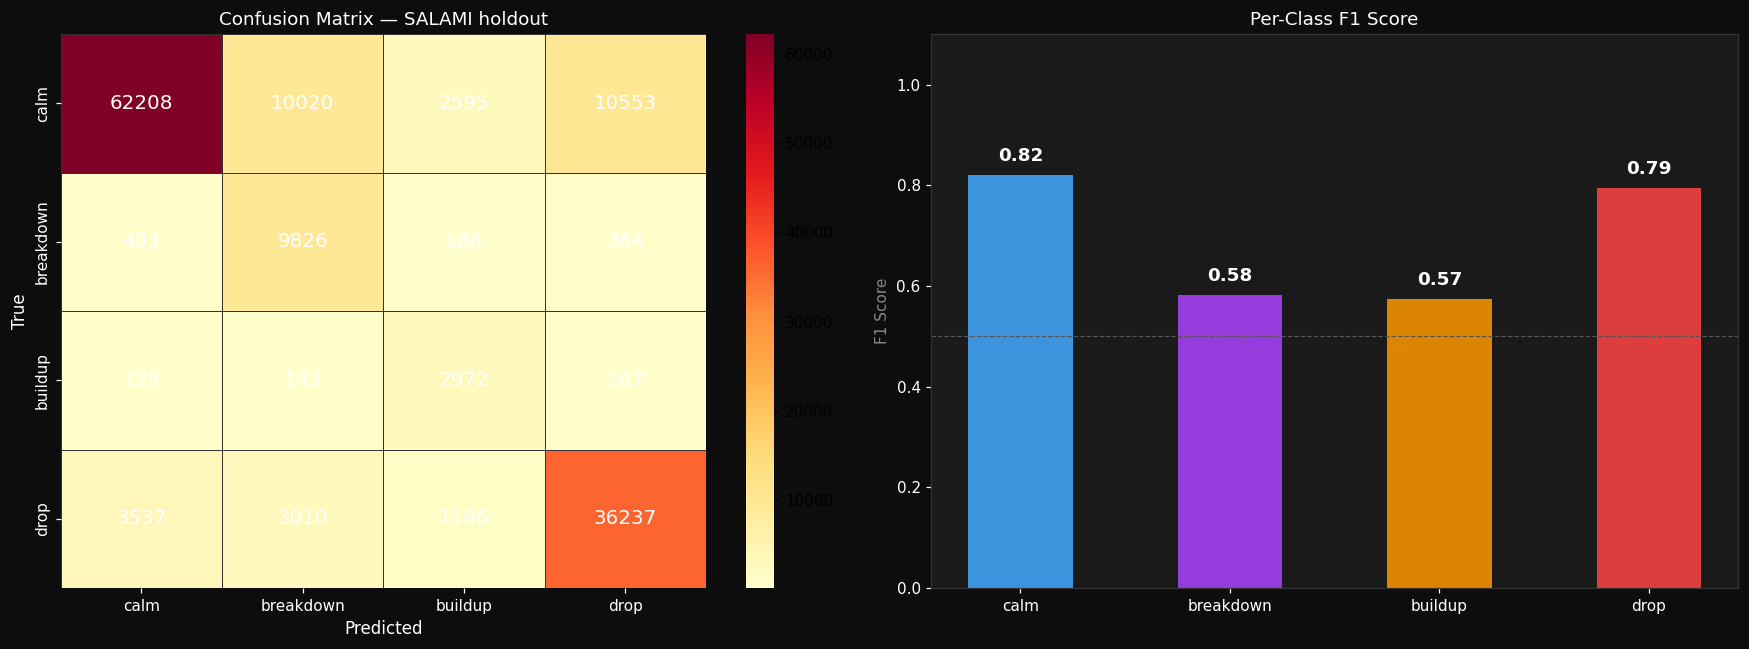


Saved → ./output/evaluation.png

💡 Reading the results:
   Confusion matrix diagonal = correct predictions (higher is better)
   Most common mistake: buildup ↔ breakdown (aurally similar)
   F1 < 0.5 on a class = model is essentially guessing for that class


In [30]:
# ── Evaluation: Confusion matrix + per-class F1 ──────────────────────────────
label_names  = ['calm', 'breakdown', 'buildup', 'drop']
label_colors = ['#44AAFF', '#AA44FF', '#FF9900', '#FF4444']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEQ_LEN = 64

# ── Build eval set from the val split inside scaler's known data ──────────────
# Use EDM holdout if available, else carve a holdout from SALAMI
if HAS_EDM_DATA:
    X_eval_raw, y_eval_raw = X_edm_test, y_edm_test
    eval_label = 'EDM holdout'
else:
    # Carve a fresh 15% holdout from SALAMI (same split train_model used internally)
    _, X_eval_raw, _, y_eval_raw = train_test_split(
        all_X, all_y, test_size=0.15, stratify=all_y, random_state=42
    )
    eval_label = 'SALAMI holdout'

# ── Run inference ─────────────────────────────────────────────────────────────
final_model.eval()
final_model.to(device)

X_eval_scaled = scaler.transform(X_eval_raw).astype(np.float32)
y_eval_int    = y_eval_raw.astype(int)

ds_eval = FrameSequenceDataset(X_eval_scaled, y_eval_int, seq_len=SEQ_LEN, stride=SEQ_LEN)
dl_eval = DataLoader(ds_eval, batch_size=128, shuffle=False, num_workers=0)

all_preds, all_true = [], []
with torch.no_grad():
    for X_batch, y_batch in dl_eval:
        logits = final_model(X_batch.to(device))
        preds  = logits.argmax(dim=-1).cpu().numpy()
        all_preds.append(preds.flatten())
        all_true.append(y_batch.numpy().flatten())

y_pred         = np.concatenate(all_preds)
y_eval_aligned = np.concatenate(all_true)

# ── Print report ──────────────────────────────────────────────────────────────
print(f'Evaluation on: {eval_label}  ({len(y_eval_aligned):,} frames)')
print(classification_report(y_eval_aligned, y_pred, target_names=label_names, zero_division=0))

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6), facecolor='#0d0d0d')

# Left: Confusion matrix
ax = axes[0]
ax.set_facecolor('#1a1a1a')
cm = confusion_matrix(y_eval_aligned, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=label_names, yticklabels=label_names,
            ax=ax, linewidths=0.5, linecolor='#333',
            annot_kws={'size': 13, 'color': 'white'})
ax.set_xlabel('Predicted', color='white', fontsize=11)
ax.set_ylabel('True',      color='white', fontsize=11)
ax.set_title(f'Confusion Matrix — {eval_label}', color='white', fontsize=12)
ax.tick_params(colors='white')
for sp in ax.spines.values(): sp.set_edgecolor('#333')

# Right: Per-class F1
ax2 = axes[1]
ax2.set_facecolor('#1a1a1a')
per_class_f1 = f1_score(y_eval_aligned, y_pred, average=None,
                         zero_division=0, labels=[0, 1, 2, 3])
bars = ax2.bar(label_names, per_class_f1, color=label_colors, alpha=0.85, width=0.5)
for bar, val in zip(bars, per_class_f1):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f'{val:.2f}', ha='center', va='bottom',
             color='white', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1.1)
ax2.set_ylabel('F1 Score', color='#888', fontsize=10)
ax2.set_title('Per-Class F1 Score', color='white', fontsize=12)
ax2.tick_params(colors='white')
ax2.axhline(0.5, color='#555', linestyle='--', linewidth=0.8)
for sp in ax2.spines.values(): sp.set_edgecolor('#333')

plt.tight_layout()
eval_path = os.path.join(OUTPUT_DIR, 'evaluation.png')
plt.savefig(eval_path, dpi=150, bbox_inches='tight', facecolor='#0d0d0d')
plt.show()
print(f'\nSaved → {eval_path}')
print()
print('💡 Reading the results:')
print('   Confusion matrix diagonal = correct predictions (higher is better)')
print('   Most common mistake: buildup ↔ breakdown (aurally similar)')
print('   F1 < 0.5 on a class = model is essentially guessing for that class')

---
## Step 13 - Test on a New Song
Run the final model on a song it has never seen to confirm the pipeline works end-to-end.

Running CNN+LSTM classifier on: ./yellowbirdbeats-funk-x-disco-bruno-mars-x-old-school-russian-mountains-292161.mp3


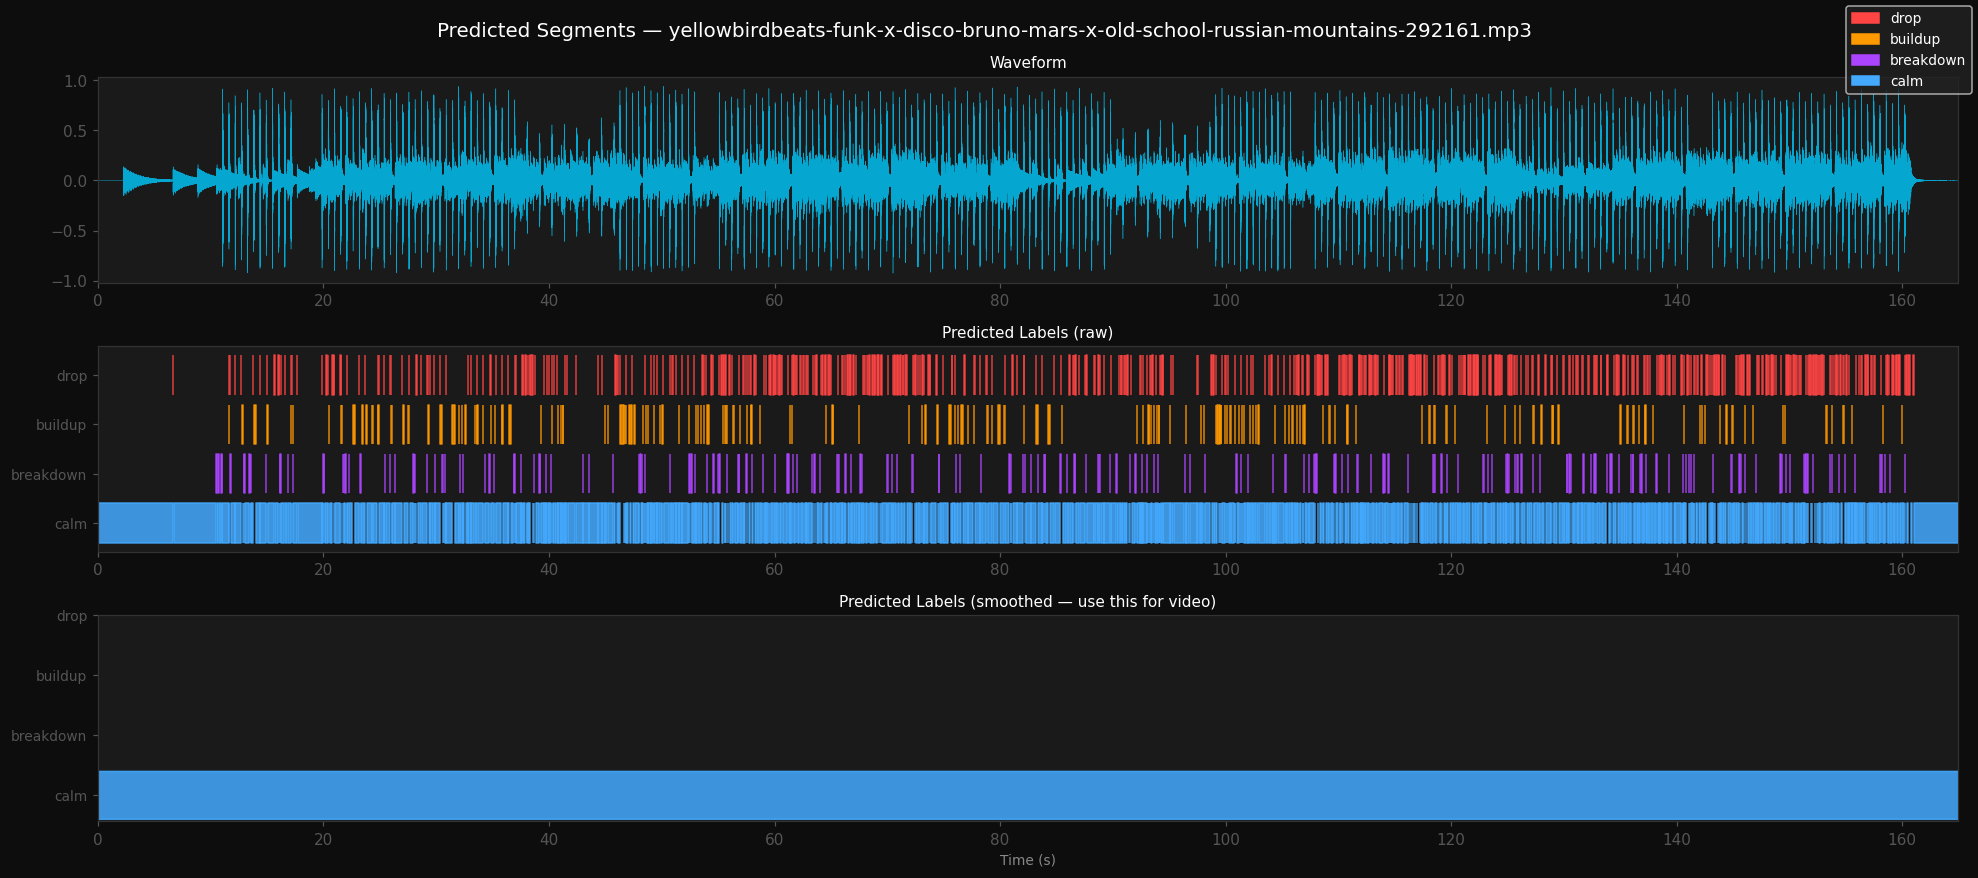

Saved → ./output/test_prediction.png

Detected segment boundaries:
  [      calm]     0.0s →  165.0s  (165.0s)


In [35]:
# ── Test on a new unseen song ─────────────────────────────────────────────────
TEST_SONG_PATH = './yellowbirdbeats-funk-x-disco-bruno-mars-x-old-school-russian-mountains-292161.mp3'
# ─────────────────────────────────────────────────────────────────────────────

if not TEST_SONG_PATH or not os.path.exists(TEST_SONG_PATH):
    print('ℹ️  Set TEST_SONG_PATH to an MP3 to test.')
else:
    print(f'Running CNN+LSTM classifier on: {TEST_SONG_PATH}')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    y_audio, sr_audio = librosa.load(TEST_SONG_PATH, sr=SR, mono=True)
    feats_test        = extract_features(y_audio, sr_audio)
    times_test        = feats_test['times']

    # Build feature matrix (dummy labels — ground truth unknown)
    dummy      = np.full(len(times_test), 0, dtype=int)
    X_song, _  = features_to_matrix(feats_test, dummy)
    X_song_sc  = scaler.transform(X_song).astype(np.float32)

    # ── Frame-level inference (chunk to avoid OOM on long tracks) ─────────────
    SEQ_LEN    = 64
    CHUNK      = 2048   # frames per forward pass
    X_tensor   = torch.tensor(X_song_sc).unsqueeze(0).to(device)   # (1, N, feat)

    final_model.eval()
    final_model.to(device)
    all_logits = []
    with torch.no_grad():
        for i in range(0, X_tensor.shape[1], CHUNK):
            chunk_in = X_tensor[:, i:i + CHUNK, :]
            all_logits.append(final_model(chunk_in))
    logits    = torch.cat(all_logits, dim=1)        # (1, N, 4)
    preds_raw = logits.squeeze(0).argmax(dim=-1).cpu().numpy()   # (N,)

    # ── Smooth: majority vote over ±2 second window ───────────────────────────
    from scipy.stats import mode
    frames_per_sec = SR / HOP
    win = max(1, int(2.0 * frames_per_sec))
    smoothed = np.array([
        mode(preds_raw[max(0, i - win): i + win], keepdims=True)[0][0]
        for i in range(len(preds_raw))
    ], dtype=int)

    # ── Plot ──────────────────────────────────────────────────────────────────
    fig, axes = plt.subplots(3, 1, figsize=(18, 8), facecolor='#0d0d0d')
    fig.suptitle(f'Predicted Segments — {os.path.basename(TEST_SONG_PATH)}',
                 color='white', fontsize=13)

    # Waveform
    ax = axes[0]
    ax.set_facecolor('#1a1a1a')
    ax.plot(np.linspace(0, times_test[-1], len(y_audio)), y_audio,
            color='#00ccff', linewidth=0.3, alpha=0.8)
    ax.set_title('Waveform', color='white', fontsize=10)
    ax.set_xlim(0, times_test[-1])
    ax.tick_params(colors='#555')
    for sp in ax.spines.values(): sp.set_edgecolor('#333')

    # Raw predictions
    ax2 = axes[1]
    ax2.set_facecolor('#1a1a1a')
    for lbl, idx_l in LABEL_INT.items():
        mask = preds_raw == idx_l
        ax2.fill_between(times_test, idx_l - 0.4, idx_l + 0.4,
                         where=mask, color=LABEL_COLORS[lbl], alpha=0.85)
    ax2.set_yticks(list(LABEL_INT.values()))
    ax2.set_yticklabels(list(LABEL_INT.keys()), color='white', fontsize=9)
    ax2.set_title('Predicted Labels (raw)', color='white', fontsize=10)
    ax2.set_xlim(0, times_test[-1])
    ax2.tick_params(colors='#555')
    for sp in ax2.spines.values(): sp.set_edgecolor('#333')

    # Smoothed predictions
    ax3 = axes[2]
    ax3.set_facecolor('#1a1a1a')
    for lbl, idx_l in LABEL_INT.items():
        mask = smoothed == idx_l
        ax3.fill_between(times_test, idx_l - 0.4, idx_l + 0.4,
                         where=mask, color=LABEL_COLORS[lbl], alpha=0.85)
    ax3.set_yticks(list(LABEL_INT.values()))
    ax3.set_yticklabels(list(LABEL_INT.keys()), color='white', fontsize=9)
    ax3.set_title('Predicted Labels (smoothed — use this for video)', color='white', fontsize=10)
    ax3.set_xlabel('Time (s)', color='#888', fontsize=9)
    ax3.set_xlim(0, times_test[-1])
    ax3.tick_params(colors='#555')
    for sp in ax3.spines.values(): sp.set_edgecolor('#333')

    handles = [mpatches.Patch(color=c, label=l) for l, c in LABEL_COLORS.items()]
    fig.legend(handles=handles, loc='upper right', facecolor='#222',
               labelcolor='white', fontsize=9)
    plt.tight_layout()
    test_path = os.path.join(OUTPUT_DIR, 'test_prediction.png')
    plt.savefig(test_path, dpi=150, bbox_inches='tight', facecolor='#0d0d0d')
    plt.show()
    print(f'Saved → {test_path}')

    # ── Print segment boundaries ───────────────────────────────────────────────
    print('\nDetected segment boundaries:')
    prev, start = smoothed[0], times_test[0]
    for i in range(1, len(smoothed)):
        if smoothed[i] != prev:
            print(f'  [{INT_LABEL[int(prev)]:>10}]  {start:6.1f}s → {times_test[i]:6.1f}s'
                  f'  ({times_test[i] - start:.1f}s)')
            prev, start = smoothed[i], times_test[i]
    print(f'  [{INT_LABEL[int(prev)]:>10}]  {start:6.1f}s → {times_test[-1]:6.1f}s'
          f'  ({times_test[-1] - start:.1f}s)')

---
## Step 14 — Summary
What was built, where files are, and what to do next.

In [24]:
print('=' * 60)
print(' SALAMI → EDM SEGMENTATION PIPELINE — COMPLETE')
print('=' * 60)
print()
print('Files saved:')
for fname in sorted(os.listdir(OUTPUT_DIR)):
    fpath = os.path.join(OUTPUT_DIR, fname)
    size_kb = os.path.getsize(fpath) / 1024
    print(f'  {fname:<40} ({size_kb:,.0f} KB)')

print()
print('What the model can do now:')
print('  ✅ Load any EDM MP3')
print('  ✅ Extract 21 audio features per frame')
print('  ✅ Predict drop / buildup / breakdown / calm per frame')
print('  ✅ Output segment boundaries with timestamps')
print()
print('Next steps for the video pipeline:')
print('  1. Load edm_segment_classifier.joblib in your video generation script')
print('  2. Map predicted labels → text prompts for AnimateDiff:')
print('       drop      → "explosive fractal neon chaos, heavy bass, glitch distortion"')
print('       buildup   → "rising electric tension, neon particles ascending"')
print('       breakdown → "dark void, slow morphing shapes, deep space"')
print('       calm      → "soft ambient flow, gentle neon gradients"')
print('  3. Generate video chunks per segment, concatenate, merge with audio via ffmpeg')
print()
if HAS_EDM_DATA:
    print('  📈 To improve accuracy: add more EDM label CSVs → re-run Steps 9 + 11')
else:
    print('  📈 To improve accuracy: add EDM label CSVs → run Steps 9 + 11')

 SALAMI → EDM SEGMENTATION PIPELINE — COMPLETE

Files saved:
  edm_segment_classifier.joblib            (507,376 KB)
  evaluation.png                           (104 KB)
  stage1_salami_model.joblib               (507,376 KB)
  test_prediction.png                      (181 KB)

What the model can do now:
  ✅ Load any EDM MP3
  ✅ Extract 21 audio features per frame
  ✅ Predict drop / buildup / breakdown / calm per frame
  ✅ Output segment boundaries with timestamps

Next steps for the video pipeline:
  1. Load edm_segment_classifier.joblib in your video generation script
  2. Map predicted labels → text prompts for AnimateDiff:
       drop      → "explosive fractal neon chaos, heavy bass, glitch distortion"
       buildup   → "rising electric tension, neon particles ascending"
       breakdown → "dark void, slow morphing shapes, deep space"
       calm      → "soft ambient flow, gentle neon gradients"
  3. Generate video chunks per segment, concatenate, merge with audio via ffmpeg

  📈 T